In [2]:
import tensorflow as tf
from tensorflow.python.client import timeline
import numpy as np
np.tau = 2*np.pi
import matplotlib.pyplot as plt
import time
from concurrent.futures import ThreadPoolExecutor

# Lamb-Oseen setup

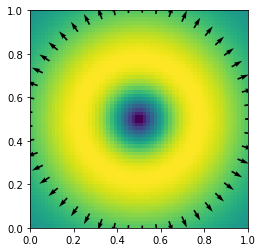

In [45]:
Nx = Ny = 60
xmin,xmax = -1,1
ymin,ymax = -1,1
X, Y = np.mgrid[xmin:xmax:Nx*1j,ymin:ymax:Ny*1j]


Gamma = 20
r0 = 0.5
nu = 0.004
P0=0
rho = 1060

rmax = np.sqrt(1.25643)*r0

def LO(t):
    V_th = Gamma/(np.tau*np.sqrt(X**2+Y**2))*(1-np.exp(-(X**2+Y**2)/(r0**2+4*nu*t)))
    V_x = V_th*Y/np.sqrt(X**2+Y**2)
    V_y = -V_th*X/np.sqrt(X**2+Y**2)
    return np.stack((V_x,V_y),axis=0)



theta = np.linspace(0,np.tau)
wall_pos = np.stack((0.5+0.49*np.cos(theta),0.5+0.49*np.sin(theta)),axis=-1)
wall_normals = np.stack((np.cos(theta),
                        np.sin(theta)),axis=-1)
vx,vy = LO(0)

plt.quiver(wall_pos[...,0],wall_pos[...,1],wall_normals[...,0],wall_normals[...,1])
plt.imshow(np.hypot(vx,vy),extent=[0,1,0,1])
plt.show()

# Divergence kernel

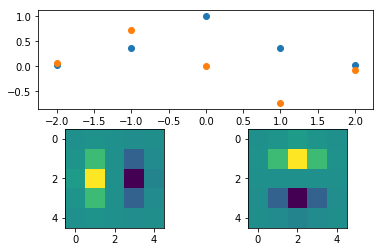

In [46]:
lins = np.linspace(-2,2,5)

# Kernel values at grid positions
kernel = [np.exp(-_x**2) for _x in lins]
kernel_div = [np.exp(-_x**2)*-2*_x for _x in lins]

div_kernel = np.dstack((np.prod(np.meshgrid(kernel_div,kernel,indexing='ij'),axis=0),np.prod(np.meshgrid(kernel,kernel_div,indexing='ij'),axis=0)))

plt.subplot(211)
plt.scatter(lins,np.exp(-lins**2))
plt.scatter(lins,np.exp(-lins**2)*2*-lins)
plt.subplot(223)
plt.imshow(np.prod(np.meshgrid(kernel_div,kernel,indexing='ij'),axis=0).T)
plt.subplot(224)
plt.imshow(np.prod(np.meshgrid(kernel,kernel_div,indexing='ij'),axis=0).T)
plt.show()


# Computation

In [64]:
# Helper function to hide the nitty gritty spline details
def compute_2d_splines(x):
    indices = tf.cast(x/dx+1,tf.int32)
    coeff = tf.gather_nd(C, XY[None]+indices[...,None,None,:])
    offsets = (tf.mod(x/dx,1)[...,None,None,:]-tf.cast(XY[None],tf.float32))*dx
    f = tf.exp(-tf.reduce_sum((offsets/sc)**2,axis=-1))
    return tf.reduce_sum(f[...,None]*coeff,axis=(1,2))


# Setup graph variables
tf.reset_default_graph()
dx = 0.15
sc = dx
n = np.mgrid[-dx:1+1.5*dx:dx,-dx:1+1.5*dx:dx].transpose(1,2,0)
nodes = tf.constant(n,dtype=tf.float32)
C = tf.Variable(np.zeros(n.shape[:-1]+(2,)),dtype=tf.float32)
Div = tf.constant(div_kernel[...,None],dtype=tf.float32)

x = tf.placeholder(np.float32)
v = tf.placeholder(np.float32)
w = tf.placeholder(np.float32)

wall = tf.placeholder(np.float32)
wall_n = tf.placeholder(np.float32)

# Common
r = tf.range(-1,3,dtype=tf.int32)
XY = tf.transpose(tf.meshgrid(r,r))

# Data fit
indices = tf.cast(x/dx+1,tf.int32)
coeff = tf.gather_nd(C, XY[None]+indices[...,None,None,:])
offsets = (tf.mod(x/dx,1)[...,None,None,:]-tf.cast(XY[None],tf.float32))*dx
f = tf.exp(-tf.reduce_sum((offsets/sc)**2,axis=-1))
model = tf.reduce_sum(f[...,None]*coeff,axis=(1,2))

# Divergence fit
model_div = tf.nn.conv2d(C[None],Div,[1, 1, 1, 1],'VALID')

# Wall fit
model_wall = tf.reduce_sum(compute_2d_splines(wall)*wall_n,axis=-1)


# Setup loss terms
Q0 = tf.reduce_mean(w[...,None]*tf.square(model[...,1:]-v[...,1:]))
Q1 = tf.reduce_mean(tf.square(coeff))
Q2 = tf.reduce_mean(tf.square(model_div))
Q3 = tf.reduce_mean(tf.square(model_wall))


k1 = 0.01
k2 = 5
k3 = 5

loss = Q0+k1*Q1+k2*Q2+k3*Q3

# Training step
train = tf.train.GradientDescentOptimizer(0.1).minimize(loss)

# Initialize variables
init = tf.global_variables_initializer()

# Execute train steps

In [69]:
lo = LO(0).transpose(1,2,0)
lo += 5*np.random.normal(size=lo.shape)
pos = np.mgrid[0:0.999:Nx*1j,0:0.999:Ny*1j].transpose(1,2,0)

weights = np.ones((Nx,Ny))#np.random.rand(Nx,Ny)

mask = np.zeros((Nx,Ny),dtype=np.bool)
mask[:] = 1
N = len(pos[mask])

with tf.Session() as sess:
    sess.run(init)  

    def trainer():
        choice = np.random.randint(0,N,size=500)
        loss_value,_ = sess.run([loss,train],feed_dict={x:pos[mask][choice].reshape(-1,2),v:lo[mask][choice].reshape(-1,2),w:weights[mask][choice].ravel(),
                                                       wall: wall_pos, wall_n: wall_normals})
    with ThreadPoolExecutor(max_workers=1) as executor:
        for i in range(200):
            executor.submit(trainer)


    c = sess.run(model,feed_dict={x:pos.reshape(-1,2)})

# Visualize results

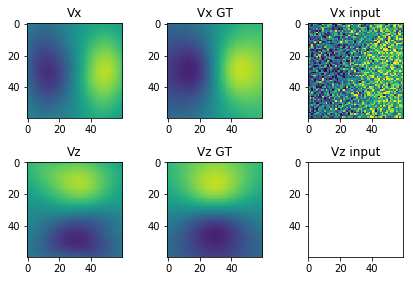

In [70]:
plt.subplot(231)
plt.imshow(c.reshape(Nx,Ny,2)[...,0],clim=(-5,5))
plt.title('Vx')
plt.subplot(232)
plt.imshow(LO(0).transpose(1,2,0)[...,0],clim=(-5,5))
plt.title('Vx GT')
plt.subplot(233)
plt.imshow(lo[...,0],clim=(-10,10))
plt.title('Vx input')

plt.subplot(234)
plt.imshow(c.reshape(Nx,Ny,2)[...,1],clim=(-5,5))
plt.title('Vz')
plt.subplot(235)
plt.imshow(LO(0).transpose(1,2,0)[...,1],clim=(-5,5))
plt.title('Vz GT')
plt.subplot(236)
plt.imshow(np.ones_like(lo[...,1])*np.nan,clim=(-10,10))
plt.title('Vz input')
plt.tight_layout()
plt.savefig('VFM.pdf')

plt.show()